In [ ]:
from utils import *

NOTEBOOK_ID = '16'
THREADS = 10
RUN_TRIM = False
RUN_ASSEMBLE = False
RUN_SLICE = False
RUN_MERGE = False
RUN_FILTER = False

# trim reads

In [ ]:
if RUN_TRIM:
    in_dir=f'{BARCODE_DIR}/01-fastq'
    out_dir=f'{BARCODE_DIR}/02-trim'
    for read_file in tqdm(glob(f'{in_dir}/*R1*.fastq.gz')):
        handle = read_file.split('/')[-1].replace('_R1_001.fastq.gz','')
        r1 = handle + '_R1_001'
        r2 = handle + '_R2_001'
        if not os.path.isfile(f'{out_dir}/{r1}_trimmed.fastq.gz'):
            os.system(f'trimmomatic PE -threads {THREADS} -phred33 \
            {in_dir}/{r1}.fastq.gz {in_dir}/{r2}.fastq.gz \
            {out_dir}/{r1}_trimmed.fastq.gz {out_dir}/{r1}_untrimmed.fastq.gz \
            {out_dir}/{r2}_trimmed.fastq.gz {out_dir}/{r2}_untrimmed.fastq.gz \
            LEADING:3 TRAILING:3 SLIDINGWINDOW:4:20 MINLEN:20')

# assemble reads

In [ ]:
if RUN_ASSEMBLE:
    in_dir = f'{BARCODE_DIR}/02-trim'
    out_dir = f'{BARCODE_DIR}/03-assemble'
    for trimmed_read in tqdm(glob(f'{in_dir}/*_trimmed.fastq.gz')):
        handle = trimmed_read.split('/')[-1].replace('_R1_001_trimmed.fastq.gz','')
        r1 = handle + '_R1_001_trimmed'
        r2 = handle + '_R2_001_trimmed'
        if not os.path.isfile(f'{out_dir}/{handle}_assembled.fastq'):
            os.system(f'gunzip -c {in_dir}/{r1}.fastq.gz > {out_dir}/{r1}.fastq')
            os.system(f'gunzip -c {in_dir}/{r2}.fastq.gz > {out_dir}/{r2}.fastq')
            os.system(f'pandaseq -f {out_dir}/{r1}.fastq -r {out_dir}/{r2}.fastq > {out_dir}/{handle}_assembled.fastq')
            os.system(f'seqtk seq -a {out_dir}/{handle}_assembled.fastq > {out_dir}/{handle}_assembled.fasta')
            os.system(f'rm {out_dir}/{r1}.fastq {out_dir}/{r2}.fastq {out_dir}/{handle}_assembled.fastq')
        break

# slice reads 

In [ ]:
if RUN_SLICE:
    in_dir = '../../02-OUTPUT/04-associate_barcodes/03-assemble'
    out_dir = '../../02-OUTPUT/04-associate_barcodes/04-extract'
    for assembly_file in tqdm(glob(f'{in_dir}/*_assembled.fasta')):
        handle = assembly_file.split('/')[-1].split('_')[0]
        extract_promoter(assembly_file,f'{out_dir}/{handle}_tiles.fasta')
        extract_barcode(assembly_file,f'{out_dir}/{handle}_barcodes.fasta')


# merge reads

In [ ]:


if RUN_MERGE:
    in_dir = f'{BARCODE_DIR}/03-assemble'
    out_dir = f'{BARCODE_DIR}/04-extract'
    for assembly_file in tqdm(glob(f'{in_dir}/*_assembled.fasta')):
        handle = assembly_file.split('/')[-1].split('_')[0]
        # tiles_df = fasta_to_df(f'{out_dir}/{handle}_tiles.fasta')
        # barcodes_df = fasta_to_df(f'{out_dir}/{handle}_barcodes.fasta')
        # merged_df = tiles_df.merge(barcodes_df.rename(columns={'seq':'barcode'}),on='ID').rename(columns={'seq':'tile'})
        tmp_df = combine_fasta(f'{out_dir}/{handle}_tiles.fasta',f'{out_dir}/{handle}_barcodes.fasta')
        tmp_df.to_pickle(f'{out_dir}/{handle}_merged.pkl')
        del tmp_df

# filter reads

In [ ]:
if RUN_FILTER:
    library_df = pd.read_csv(f'{LIBRARY_DIR}/library_optimized_final.csv')
    library_df['tile'] = library_df['na_seq+overhangs'].apply(lambda x: x.replace('GCGGGCTCTACTTCATCGGCTAGC','').replace('TGATAACTAGCTGAGGGCCCG','').upper())
    library_df = library_df.drop(columns=['na_seq+overhangs'])
    in_dir = f'{BARCODE_DIR}/04-extract'
    out_dir = f'{BARCODE_DIR}/04-extract'
    for merged_file in tqdm(glob(f'{in_dir}/*_merged.pkl')):
        handle = merged_file.split('/')[-1].replace('_merged.pkl','')
        tmp_df = pd.read_pickle(merged_file)
        merged_df = library_df.merge(tmp_df.drop(columns=['ID']),on='tile')
        merged_df.to_pickle(f'{out_dir}/{handle}_filtered.pkl')

In [7]:
out_file = f'{BARCODE_DIR}/05-pooled/lucas_library.pkl'
if not os.path.isfile(out_file):
    df_21 = pd.read_pickle('../../02-OUTPUT/09-associate_barcodes/04-extract/eLW028-QC21_filtered.pkl')
    df_21['sequencing_file'] = 'QC21'
    df_22 = pd.read_pickle('../../02-OUTPUT/09-associate_barcodes/04-extract/eLW028-QC22_filtered.pkl')
    df_22['sequencing_file'] = 'QC22'
    df_23 = pd.read_pickle('../../02-OUTPUT/09-associate_barcodes/04-extract/eLW028-QC23_filtered.pkl')
    df_23['sequencing_file'] = 'QC23'
    df_24 = pd.read_pickle('../../02-OUTPUT/09-associate_barcodes/04-extract/eLW028-QC24_filtered.pkl')
    df_24['sequencing_file'] = 'QC24'

    df = pd.concat([
        df_21,df_22,df_23,df_24
    ]).reset_index(drop=True)
    df.to_pickle(out_file)
else:
    df = pd.read_pickle(out_file)
df

,seq_ID,tile,barcode,sequencing_file
0,eLW028-0000,TCAATTGACAGTGCAGCCCACCACGACAACTCCACAATCCCGCTCG...,TGAGAACGACAACA,QC21
1,eLW028-0000,TCAATTGACAGTGCAGCCCACCACGACAACTCCACAATCCCGCTCG...,GATAAAAAACATAG,QC21
2,eLW028-0000,TCAATTGACAGTGCAGCCCACCACGACAACTCCACAATCCCGCTCG...,AGAAATTACAAGTC,QC21
3,eLW028-0000,TCAATTGACAGTGCAGCCCACCACGACAACTCCACAATCCCGCTCG...,AGATTTAGTATAGG,QC21
4,eLW028-0000,TCAATTGACAGTGCAGCCCACCACGACAACTCCACAATCCCGCTCG...,GTTAGTCAAACCGA,QC21
...,...,...,...,...
55878421,eLW028-9835,ATGTTGTTTCCATGTGGTGTTTTGTTTTTGTCTGTTTTTTCTATTT...,GGAATGGTAACCCA,QC24
55878422,eLW028-9835,ATGTTGTTTCCATGTGGTGTTTTGTTTTTGTCTGTTTTTTCTATTT...,GCCTTAGATCTATG,QC24
55878423,eLW028-9835,ATGTTGTTTCCATGTGGTGTTTTGTTTTTGTCTGTTTTTTCTATTT...,TCACAGAGCGGCTG,QC24
55878424,eLW028-9835,ATGTTGTTTCCATGTGGTGTTTTGTTTTTGTCTGTTTTTTCTATTT...,AGAGATCGAAATTG,QC24


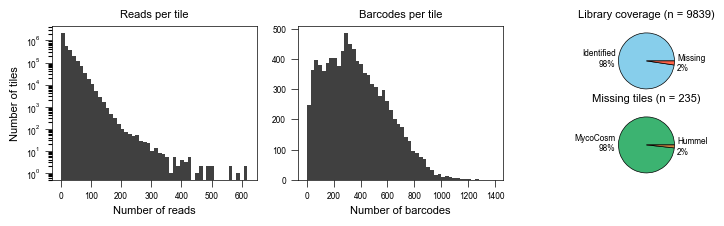

In [8]:
fig = plt.figure(figsize=(9,2))
gs = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0:2, 0])
ax2 = fig.add_subplot(gs[0:2, 1])
ax3 = fig.add_subplot(gs[0:1, 2])
ax4 = fig.add_subplot(gs[1:2, 2])

g = sns.histplot(data=df.groupby(['seq_ID','barcode']).count(),
             x='tile',
             element='step',
             color='black',
             edgecolor=None,
             ax=ax1,
             bins=50)
g.set(yscale='log',title=f'Reads per tile',ylabel='Number of tiles',xlabel='Number of reads')

g = sns.histplot(data=df.groupby(['seq_ID']).nunique(),
             x='barcode',
             element='step',
             color='black',
             edgecolor=None,
             ax=ax2,
             bins=50)
g.set(title=f'Barcodes per tile',ylabel=None,xlabel='Number of barcodes')

library_df = pd.read_csv(f'{LIBRARY_DIR}/library_optimized_final.csv')
missing = library_df[~library_df['seq_ID'].isin(df['seq_ID'])].copy()
missing['na_seq+overhangs'] = missing['na_seq+overhangs'].apply(lambda x: x.replace('GCGGGCTCTACTTCATCGGCTAGC','').replace('TGATAACTAGCTGAGGGCCCG','').upper())
tmp_df = pd.read_csv(f'../../01-INPUT/02-datasets/01-hummel/all_acts_with_empty_hummel.csv').rename(columns={'Activity_500k_Rat':'activity'})
tmp_df['aa_seq'] = tmp_df['ArrayDNA'].apply(lambda x: str(Seq(x).translate()).replace('*',''))
tmp_df = tmp_df[tmp_df['aa_seq'].apply(lambda x: len(x) == 53)]
tmp_df = tmp_df.loc[(tmp_df['activity'] != 0.0) & (~np.isnan(tmp_df['activity']))]
tmp_df = tmp_df.loc[tmp_df.loc[:, ['aa_seq', 'activity']].drop_duplicates().index].reset_index(drop=True)
hummel_df = pd.read_csv(f'{LIBRARY_DIR}/hummel_test.csv')
hummel_df = hummel_df.merge(tmp_df[['aa_seq','ArrayDNA']],on=['aa_seq'])
hummel_df['dataset'] = 'Hummel'
sanborn_df = pd.read_csv(f'{LIBRARY_DIR}/sanborn_test.csv')
sanborn_df['dataset'] = 'Sanborn'
mycocosm_df = pd.read_csv(f'{LIBRARY_DIR}/mycocosm_test_codonoptimized.csv')
mycocosm_df['dataset'] = 'MycoCosm'
library_df = pd.concat([
    sanborn_df[['tile_id','protein sequence','DNA','dataset']].rename(columns={'tile_id':'ID','protein sequence':'aa_seq','DNA':'na_seq'}),
    hummel_df[['ID','aa_seq','ArrayDNA','dataset']].rename(columns={'ArrayDNA':'na_seq'}),
    mycocosm_df[['tile_id','seq','na_seq','dataset']].rename(columns={'tile_id':'ID','seq':'aa_seq'})
]).reset_index(drop=True)
missing = library_df[library_df['na_seq'].isin(missing['na_seq+overhangs'])]

data = [len(library_df),len(missing)]
labels = ['Identified','Missing']
labels = [f'{label}\n{100*(data[i]/sum(data)):.0f}%' for i, label in enumerate(labels)]
ax3.title.set_text(f'Library coverage (n = {len(library_df)})')

wedges, texts = ax3.pie(data,labels=labels,colors=['skyblue','tomato'])
for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('black')

tmp = missing.groupby(['dataset']).count()
labels = list(tmp.index)[::-1]
data = list(tmp['ID'])[::-1]
labels = [f'{label}\n{100*(data[i]/sum(data)):.0f}%' for i, label in enumerate(labels)]
ax4.title.set_text(f'Missing tiles (n = {len(missing)})')
wedges, texts  = ax4.pie(data,labels=labels,colors=['mediumseagreen','peru'])
for w in wedges:
    w.set_linewidth(0.5)
    w.set_edgecolor('black')

fig.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-barcode_association.png',**FIGURE_PARAMS)